Scaricamento dati da 2020-01-10 a 2025-01-10
--- Elaborazione LLY ---
Dati giornalieri caricati per LLY.
Dati intraday (30m) caricati per LLY.
--- Elaborazione CAL ---
Dati giornalieri caricati per CAL.
Dati intraday (30m) caricati per CAL.
--- Elaborazione WMT ---
Dati giornalieri caricati per WMT.
Dati intraday (30m) caricati per WMT.
--- Elaborazione MGY ---
Dati giornalieri caricati per MGY.
Dati intraday (30m) caricati per MGY.
--- Elaborazione KR ---
Dati giornalieri caricati per KR.
Dati intraday (30m) caricati per KR.
--- Elaborazione FCN ---
Dati giornalieri caricati per FCN.
Dati intraday (30m) caricati per FCN.
--- Elaborazione NYT ---
Dati giornalieri caricati per NYT.
Dati intraday (30m) caricati per NYT.
--- Elaborazione TDS ---
Dati giornalieri caricati per TDS.
Dati intraday (30m) caricati per TDS.
--- Elaborazione MUR ---
Dati giornalieri caricati per MUR.
Dati intraday (30m) caricati per MUR.
Download completato.


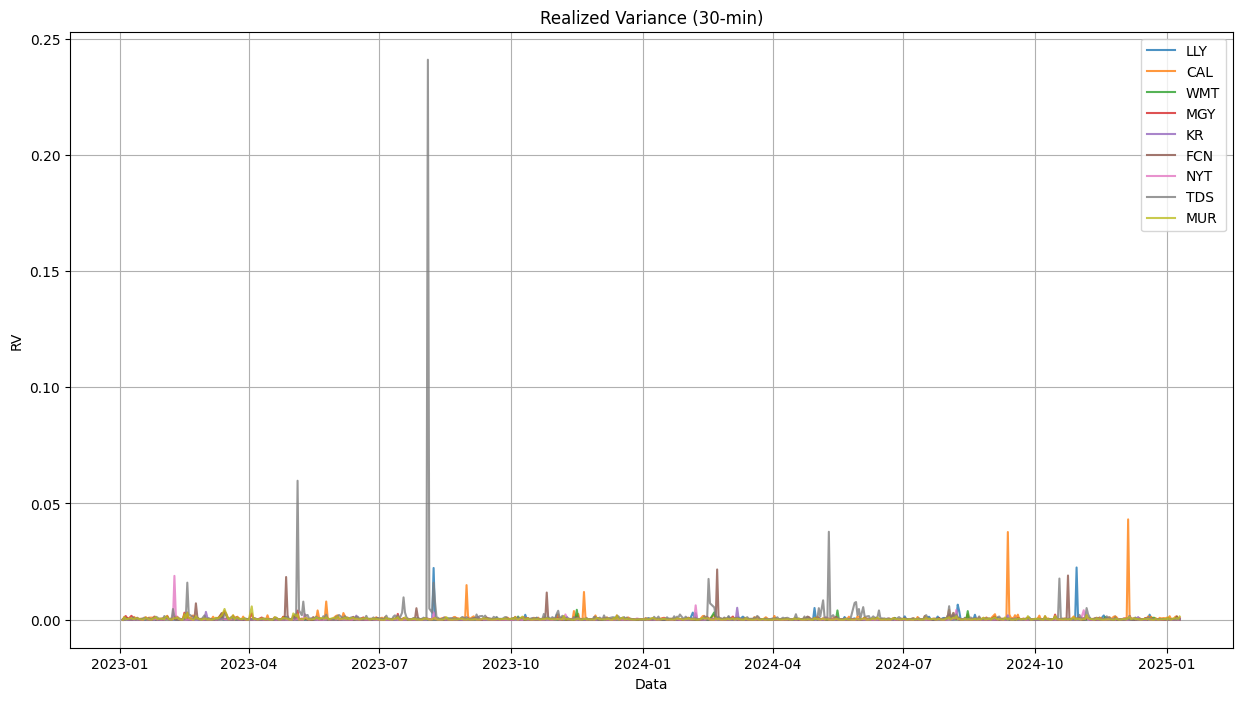

In [1]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

# Connessione a TradingView, se ti da un errore rirunna perché fa schifo a o cazz
tv = TvDatafeed()
# Imposta le date di inizio e fine per il download dei dati. Data di fine è importante per l'ultima cella del codice se vuoi testare realmente
#le performance del portafoglio, altrimenti se non te ne fotte un cazzo puoi mettere una data di fine più recente
start_date = date(2020, 1, 10)
end_date = date(2025, 1, 10)

# Specifica i titoli di cui scaricare i dati e il relativo exchange.
#Funziona con ogni asset listato su TV
tickers = [
    ("LLY", "NYSE"),  
    ("CAL", "NYSE"),  
    ("WMT", "NYSE"),  
    ("MGY", "NYSE"),  
    ("KR", "NYSE"),   
    ("FCN", "NYSE"),  
    ("NYT", "NYSE"),  
    ("TDS", "NYSE"), 
    ("MUR", "NYSE"),  
]


# I dati scaricati saranno salvati qui per ogni ticker.
daily_data = {}
intraday_data = {}
print(f"Scaricamento dati da {start_date} a {end_date}")
for ticker, exchange in tickers:
    print(f"--- Elaborazione {ticker} ---")
    df_daily = tv.get_hist(symbol=ticker, exchange=exchange,
                           interval=Interval.in_daily,                     #se cambi questo vedi la nomenclatura sulla pagina della libreria
                           n_bars=(end_date - start_date).days + 500)
    if df_daily is not None and not df_daily.empty:
        df_daily.index = pd.to_datetime(df_daily.index).date              # Converti l'indice in formato data
        df_daily = df_daily.loc[start_date:end_date]                      # Filtra per l'intervallo di date
        daily_data[ticker] = df_daily                                     # Salva i dati giornalieri
        print(f"Dati giornalieri caricati per {ticker}.")
    else:
        print(f"Errore: Dati giornalieri non disponibili per {ticker}.")  #se si bugga la libreria l'errore te lo da qua


#Sta roba non serve a un cazzo, ma la lascio per sicurezza perché si può estendere forse con la RV ma non l'ho mai visto farr
    df_30m = tv.get_hist(symbol=ticker, exchange=exchange,
                         interval=Interval.in_30_minute,
                         n_bars=20000)                                  #molto alto, alla peggio non ti scarca i dati intraday
    if df_30m is not None and not df_30m.empty:
        df_30m.index = pd.to_datetime(df_30m.index)                     # Converti l'indice in formato data e ora
        df_30m = df_30m[(df_30m.index.date >= start_date) &
                         (df_30m.index.date <= end_date)]               #Filtra per l'intervallo di date è una cazzata ma cosi eviti di avere dati fuori range
        if not df_30m.empty:
            intraday_data[ticker] = df_30m                              # Salva i dati intraday
            print(f"Dati intraday (30m) caricati per {ticker}.")
    else:
        print(f"Errore: Dati intraday non disponibili per {ticker}.")
print("Download completato.")






# Calcolo delle Realized Variance (RV)
realized_variances = {}
for ticker, df in intraday_data.items():
    #df = df.sort_index()  # Ordina i dati per data e ora
    log_returns = np.log(df['close'] / df['close'].shift(1))                  # Calcola i rendimenti logaritmici
    rv = log_returns.groupby(df.index.date).apply(lambda x: np.nansum(x**2))  # Calcola la somma dei quadrati dei rendimenti (lamdba è una funzione anonima, comoda per sta roba)
    rv.index.name = 'Date'                                                   
    realized_variances[ticker] = rv                                           # Salva la Realized Variance


# Traccia un grafico della RV per ciascun ticker che ovviamente sarà illeggibile perché sono troppi
plt.figure(figsize=(15, 8))
for ticker, rv in realized_variances.items():                    
    plt.plot(rv.index, rv.values, label=ticker, alpha=0.8)
plt.title('Realized Variance (30-min)')
plt.xlabel('Data')
plt.ylabel('RV')
plt.legend()
plt.grid(True)
plt.show()

# Allineamento dei dati giornalieri con la Realized Variance  in modo da avere solo i dati che servono
matched_daily_data = {}
for ticker, rv in realized_variances.items():
    if ticker in daily_data:
        df_daily = daily_data[ticker]
        matched = df_daily[df_daily.index.isin(rv.index)]  # Filtra le date corrispondenti
        matched_daily_data[ticker] = matched

#Tutta sta parte della RV ripeto non serve a un cazzo, ma la lascio per sicurezza

MLE dei parametri media, varianza e jump. Li compara con quelli sotrici che sorpresona saranno diversi

=== Stima Parametri (parallelo) ===
Ticker   |     mu_MLE |    mu_hist |  sigma_MLE | sigma_hist |   lambda |      muJ |   sigmaJ
LLY      |   0.001605 |   0.001398 |   0.014023 |   0.020264 |   0.0929 |   0.0104 |   0.0469
CAL      |   0.001056 |  -0.000046 |   0.032238 |   0.046863 |   0.0590 |   0.0040 |   0.1398
WMT      |   0.000797 |   0.000696 |   0.009949 |   0.014240 |   0.0526 |   0.0004 |   0.0444
MGY      |   0.001145 |   0.000548 |   0.025783 |   0.034578 |   0.1366 |  -0.0001 |   0.0623
KR       |   0.000744 |   0.000584 |   0.012344 |   0.017852 |   0.1355 |   0.0006 |   0.0350
FCN      |   0.000620 |   0.000410 |   0.012232 |   0.020529 |   0.0773 |  -0.0089 |   0.0586
NYT      |   0.000602 |   0.000387 |   0.014703 |   0.020763 |   0.0908 |   0.0001 |   0.0486
TDS      |   0.000958 |   0.000242 |   0.022195 |   0.037699 |   0.0623 |   0.0062 |   0.1219
MUR      |   0.001010 |   0.000161 |   0.028108 |   0.041284 |   0.0987 |  -0.0086 |   0.0958

=== Simulazione Monte C

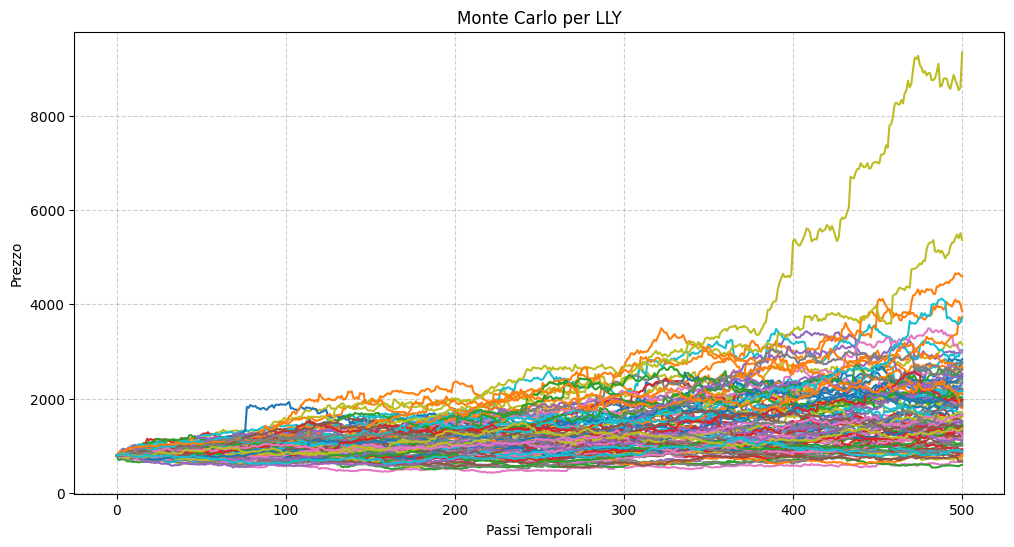

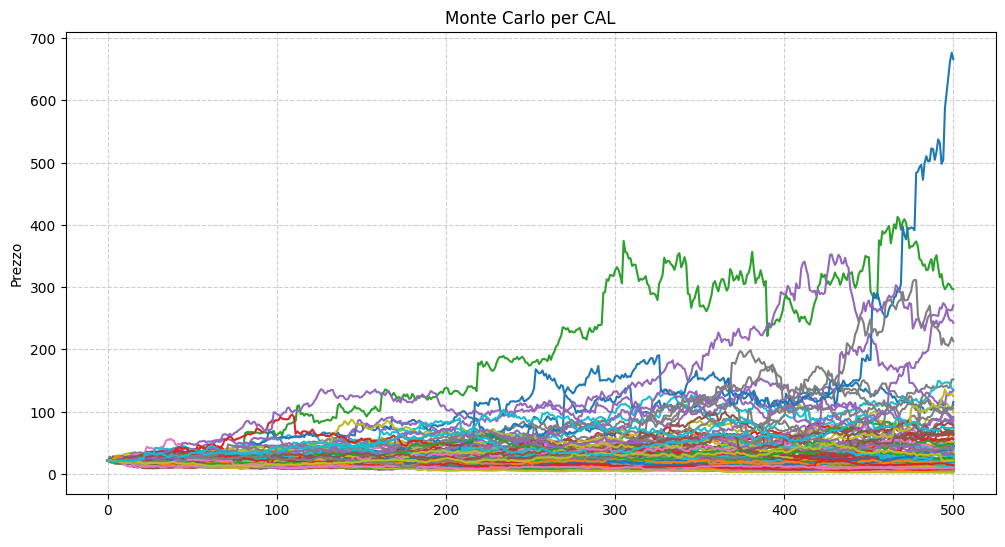

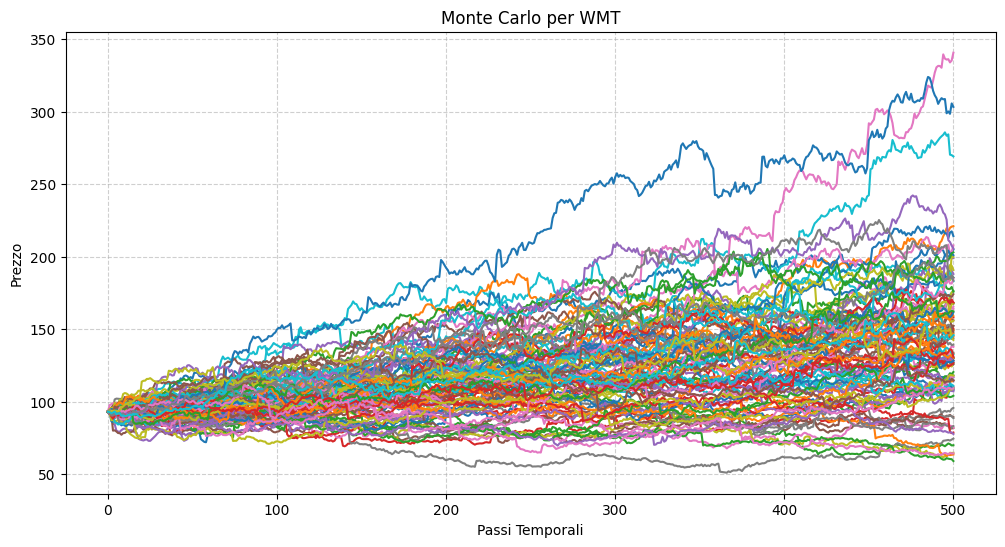

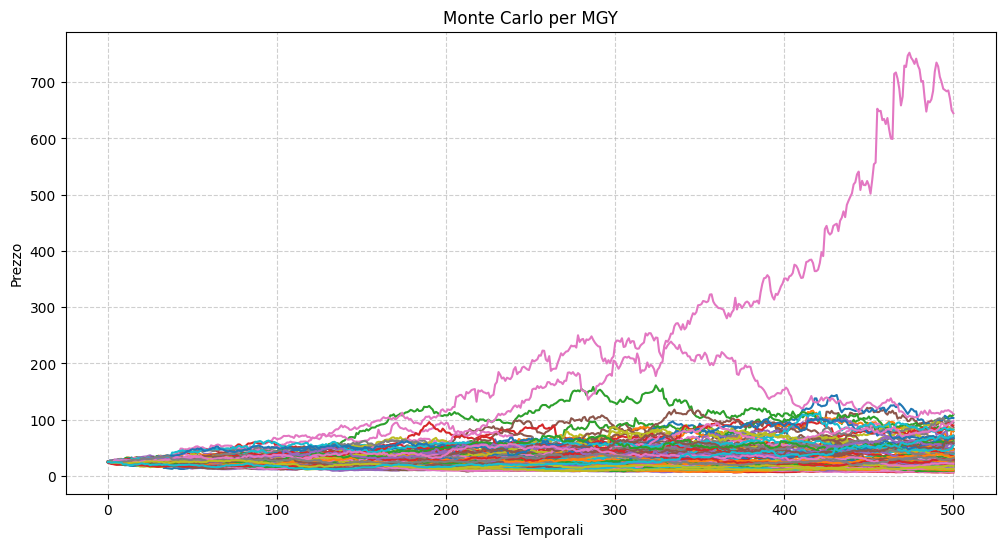

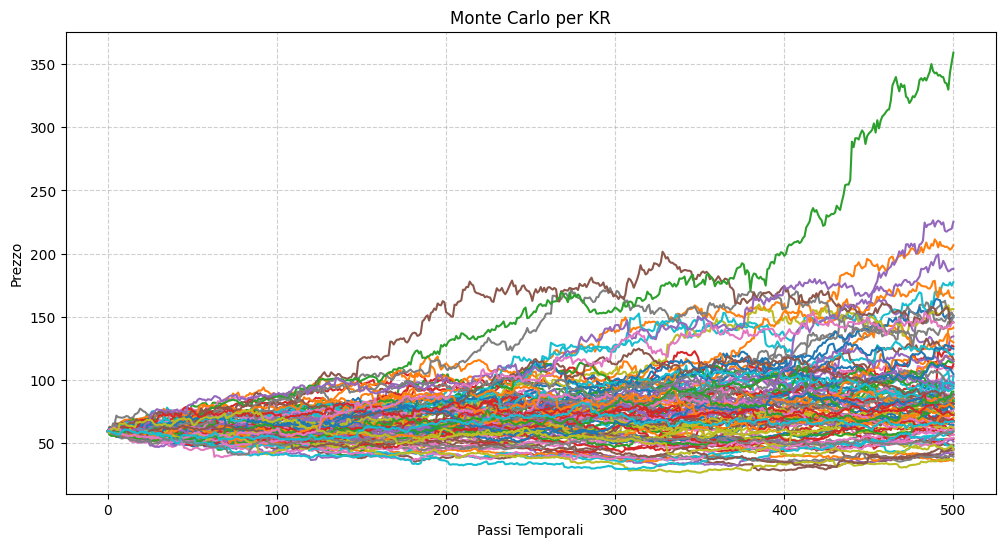

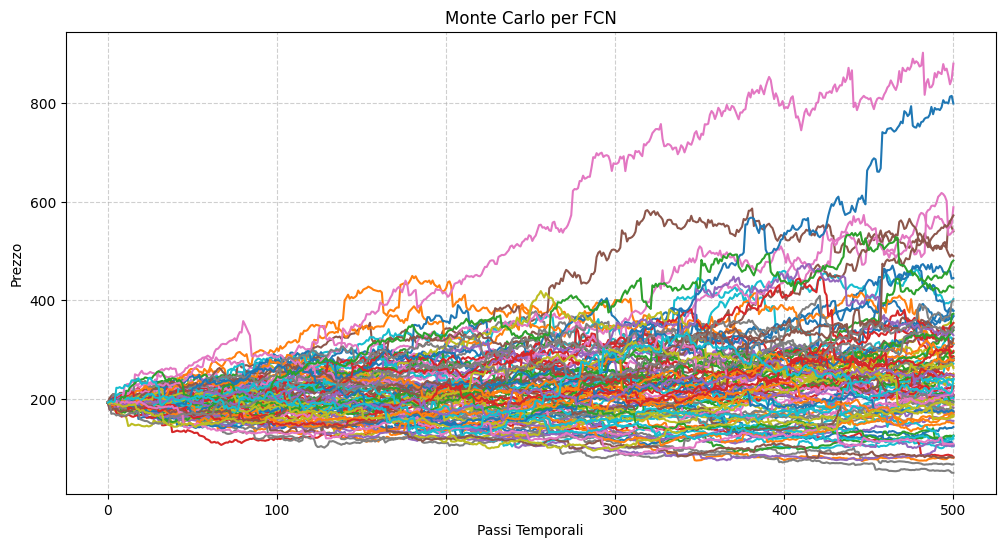

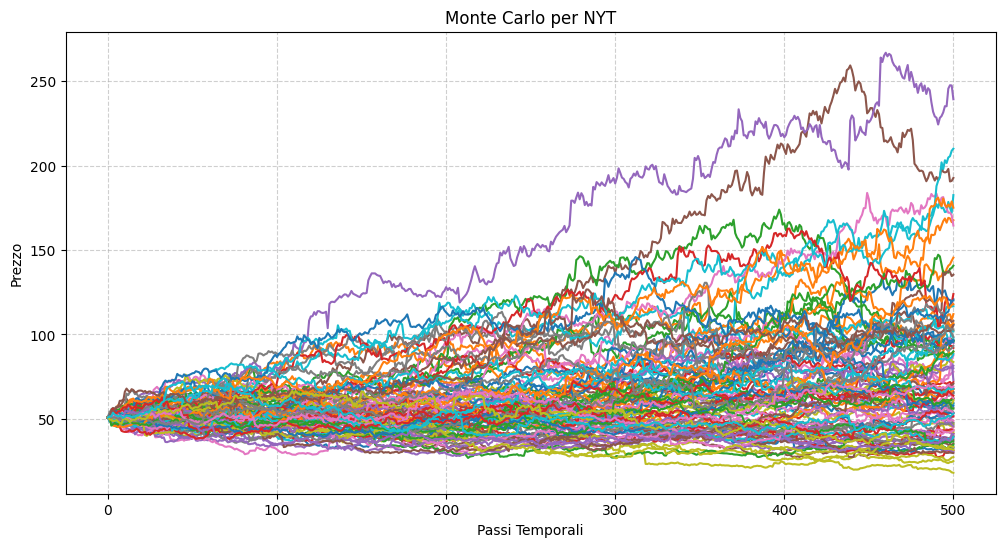

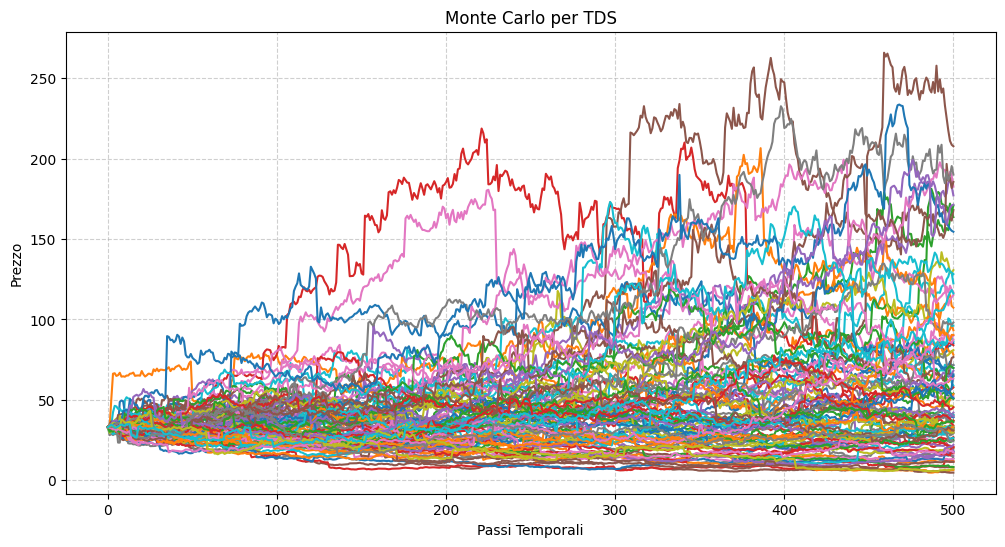

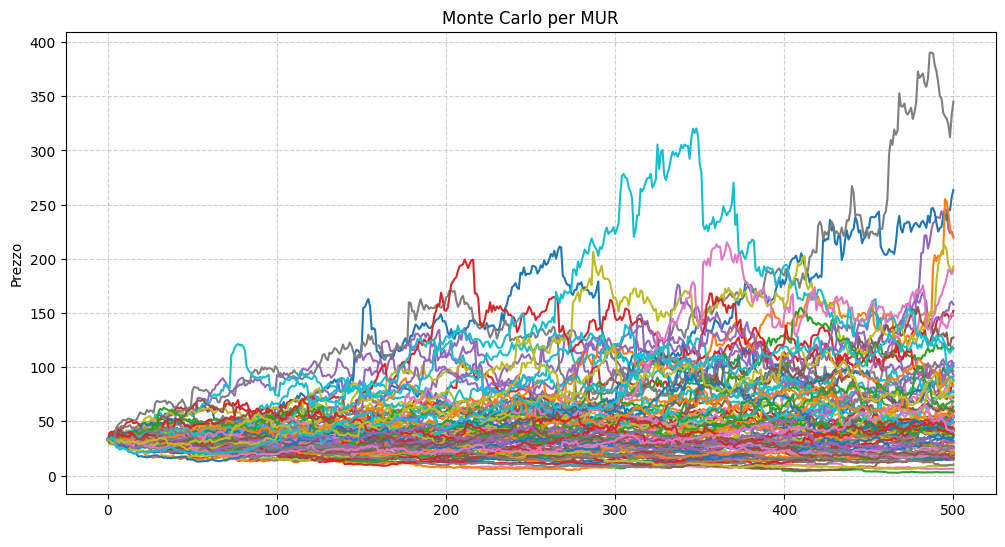

In [2]:
from scipy.stats import norm
from scipy.optimize import minimize
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)  # Ignora avvisi runtime

# --- Funzioni principali ---
def neg_loglik_merton(params, r, dt=1.0):
    mu, sigma, lam, muJ, sigmaJ = params
    kappa = np.exp(muJ + 0.5 * sigmaJ**2) - 1  
    p1 = (1 - lam * dt) * norm.pdf(r, loc=(mu - 0.5 * sigma**2 - lam * kappa) * dt, scale=sigma * np.sqrt(dt))
    m_eff, v_eff = (mu - 0.5 * sigma**2 - lam * kappa) * dt + muJ, sigma**2 * dt + sigmaJ**2
    p2 = lam * dt * norm.pdf(r, loc=m_eff, scale=np.sqrt(v_eff))
    return -np.sum(np.log(p1 + p2 + 1e-15))

def estimate_params_for_ticker(ticker, df_daily):
    log_ret = np.log(df_daily['close'] / df_daily['close'].shift(1)).dropna()  # Log-rendimenti
    mu_hist, sigma_hist = log_ret.mean(), log_ret.std(ddof=1)  # Stime storiche
    init = np.array([mu_hist, sigma_hist, 0.1, 0.0, 0.1])      #stime iniziali, se parti dalla media e std è piu veloce ma puoi mettere qualsiasi valore
    bounds = [(-np.inf, np.inf), (1e-6, None), (1e-6, 1.0), (-np.inf, np.inf), (1e-6, None)]
    res = minimize(neg_loglik_merton, init, args=(log_ret.values,), bounds=bounds, method='L-BFGS-B')
    return ticker, res.x, (mu_hist, sigma_hist)

def run_simulation_for_ticker(ticker, params, S0, n_sim, n_steps, dt):
    mu, sigma, lam, muJ, sigmaJ = params
    price_paths = np.zeros((n_steps + 1, n_sim)); 
    price_paths[0] = S0
    kappa = np.exp(muJ + 0.5 * sigmaJ**2) - 1
    drift = mu - lam * kappa
    for t in range(1, n_steps + 1):
        Z, N = np.random.standard_normal(n_sim), np.random.poisson(lam * dt, n_sim)
        J = N * np.random.normal(muJ, sigmaJ, n_sim)
        price_paths[t] = price_paths[t-1] * np.exp((drift * dt) + (sigma * np.sqrt(dt) * Z) + J)
    print(f"Simulazione {ticker} completata."); return ticker, price_paths

# --- Sezione 1: Stima Parametri ---
print("=== Stima Parametri (parallelo) ===")
estimation_results = Parallel(n_jobs=-1)(
    delayed(estimate_params_for_ticker)(ticker, df) for ticker, df in daily_data.items())

mle_params = {}
print(f"{'Ticker':<8} | {'mu_MLE':>10} | {'mu_hist':>10} | {'sigma_MLE':>10} | {'sigma_hist':>10} | {'lambda':>8} | {'muJ':>8} | {'sigmaJ':>8}")
for ticker, mle_p, hist_p in estimation_results:
    mle_params[ticker] = mle_p; mu_mle, sigma_mle, lambda_mle, muJ_mle, sigmaJ_mle = mle_p
    mu_hist, sigma_hist = hist_p
    print(f"{ticker:<8} | {mu_mle:10.6f} | {mu_hist:10.6f} | {sigma_mle:10.6f} | {sigma_hist:10.6f} | {lambda_mle:8.4f} | {muJ_mle:8.4f} | {sigmaJ_mle:8.4f}")

# --- Sezione 2: Simulazione Monte Carlo SE VUOI CAMBIARE QUALCOSA CAMBIA QUI ---
print("\n=== Simulazione Monte Carlo ===")
n_sim, n_steps, dt = 1000, 500, 1  # Configurazione simulazioni: se alzi il numero di simulazioni 
#inevitabilmente convergi verso la media del processo. Se quindi ti fidi poco dei dati storici, alza riduci il numero di simulazioni
simulation_args = [(ticker, params, daily_data[ticker]['close'].iloc[-1], n_sim, n_steps, dt) for ticker, params in mle_params.items()]
simulation_results_list = Parallel(n_jobs=-1)(delayed(run_simulation_for_ticker)(*args) for args in simulation_args)
simulation_results = dict(simulation_results_list)
print("\n=== Grafici Simulazioni ===")
for ticker, price_paths in simulation_results.items():
    plt.figure(figsize=(12, 6)); plt.plot(price_paths[:, :100])
    plt.title(f"Monte Carlo per {ticker}"); plt.xlabel("Passi Temporali"); plt.ylabel("Prezzo")
    plt.grid(True, linestyle='--', alpha=0.6); plt.show()


Ottimizzazione classica di Markowitz (fatta come quelli di RIot. Questa usa i dati STORICI). In genere Markowitz da soluzioni concentrate, quà la concentrazione ci sta ma meno del solito. Probabilemte culo. Comunque ti accorgi dei problemi se dei pesi sono 0 e altri molto bassi

In [3]:
# Preparazione dati
all_prices = pd.concat([df['close'].rename(t) for t, df in daily_data.items()], axis=1)
log_returns = np.log(all_prices / all_prices.shift(1)).dropna()

# Parametri annualizzati perché senno non ha senso
expected_returns = log_returns.mean() * 252
cov_matrix = log_returns.cov() * 252

# Funzione volatilità portafoglio
def portfolio_volatility(w, cov): 
    return np.sqrt(w.T @ cov @ w)

num_assets = len(log_returns.columns)
#Se cambi 0 puoi impostare il peso minimo per ogni asset. Tipo 0.05 imposta un peso minimo del 5% per ogni asset
#Può pure essere negativo se shorti ma in generere non si fa
bounds = [(0, 1)] * num_assets                                  
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
initial_weights = np.ones(num_assets) / num_assets

# Ottimizzazione (minimizza volatilità)
res = minimize(portfolio_volatility, initial_weights, args=(cov_matrix,),
               method='SLSQP', bounds=bounds, constraints=constraints)
weights = res.x
weights_df = pd.DataFrame({'Ticker': log_returns.columns, 'Peso': weights})
weights_df['Peso'] = weights_df['Peso'].map("{:.4%}".format)

# Performance portafoglio
risk_free = 0.02                                    #se per caso non hai i dati annualizzati mettilo 0
port_return = (expected_returns @ weights)
port_vol = portfolio_volatility(weights, cov_matrix)
sharpe = (port_return - risk_free) / port_vol

print(weights_df.to_string(index=False))
print(f"\nRendimento atteso: {port_return:.4%}")
print(f"Volatilità: {port_vol:.4%}")
print(f"Sharpe Ratio: {sharpe:.2f}")


Ticker     Peso
   LLY 12.5866%
   CAL  2.1863%
   WMT 32.1190%
   MGY  2.6713%
    KR 19.4968%
   FCN 16.9373%
   NYT 13.9338%
   TDS  0.0689%
   MUR  0.0000%

Rendimento atteso: 16.3911%
Volatilità: 17.0339%
Sharpe Ratio: 0.84


Ottimizzazione simile a quelli di riot. Il modello usa i jump stimati con MLE e poi ci mette una concatenazione numerica diversa per non appiattire sulla media. I pesi sono leggermente più distribuiti perché usare i jump rende meno "forte" la dominanza di un asset sull'altro

In [4]:
simulated_log_returns_all = {}

for ticker, paths in simulation_results.items():
    log_rets = np.log(paths[1:] / paths[:-1])  
    # "Appiattisco" in un unico vettore tutti i rendimenti simulati per il ticker
    # E' la cosa piu importante. Loro hanno fatto la media con 1000 simulazioni quindi gia converge alla media
    # Se poi medi ancora le traiettorie, ovviamente grazie al cazzo che convergi alla media. Questa cosa
    # Invece ti fa una time series dannatamente lunga di rendimenti simulati con jump per ogni ticker
    simulated_log_returns_all[ticker] = log_rets.flatten()


#il codice è letteralmente uguale
simulated_log_returns_df = pd.DataFrame(simulated_log_returns_all)
trading_days = 252
future_expected_returns = simulated_log_returns_df.mean() * trading_days
future_cov_matrix = simulated_log_returns_df.cov() * trading_days

# Funzione volatilità portafoglio (come prima)
def portfolio_volatility(w, cov):
    return np.sqrt(w.T @ cov @ w)

num_assets = len(simulated_log_returns_df.columns)
bounds = [(0, 1)] * num_assets                                     #anche qua, cambia i pesi minimi se vuoi
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
initial_weights = np.ones(num_assets) / num_assets

print("=== Ottimizzazione Portafoglio (dati simulati - tutti i percorsi) ===")

res = minimize(portfolio_volatility, initial_weights, args=(future_cov_matrix,),
               method='SLSQP', bounds=bounds, constraints=constraints)

weights = res.x
weights_df = pd.DataFrame({'Ticker': simulated_log_returns_df.columns, 'Peso': weights})
weights_df['Peso'] = weights_df['Peso'].map("{:.4%}".format)

risk_free = 0.02
port_return = future_expected_returns @ weights
port_vol = portfolio_volatility(weights, future_cov_matrix)
sharpe = (port_return - risk_free) / port_vol

print(weights_df.to_string(index=False))
print(f"\nRendimento atteso: {port_return:.4%}")
print(f"Volatilità: {port_vol:.4%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

=== Ottimizzazione Portafoglio (dati simulati - tutti i percorsi) ===
Ticker     Peso
   LLY 13.6001%
   CAL  2.5057%
   WMT 28.3283%
   MGY  4.6853%
    KR 17.2443%
   FCN 13.4018%
   NYT 13.0797%
   TDS  3.8905%
   MUR  3.2642%

Rendimento atteso: 18.9088%
Volatilità: 12.1753%
Sharpe Ratio: 1.39


Questo pezzo serve a vedere quanto avresti guadagnato usando i pesi ottimizzati contro una strategia equally weight. Devi solo impostare la data di "acquisto del portafoglio nel passato" che è lo stesso giorno che hai messo come fine nella prima cella

Valutazione portafoglio dal 2025-01-10 al 2025-06-18
Pesi utilizzati (da simulazione):
LLY    13.60%
CAL     2.51%
WMT    28.33%
MGY     4.69%
KR     17.24%
FCN    13.40%
NYT    13.08%
TDS     3.89%
MUR     3.26%
dtype: object
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  9 of 9 completed



--- Performance Reale ---
Rendimento cumulato portafoglio ottimizzato: 0.84%
Rendimento cumulato benchmark (pesi uguali): -4.56%


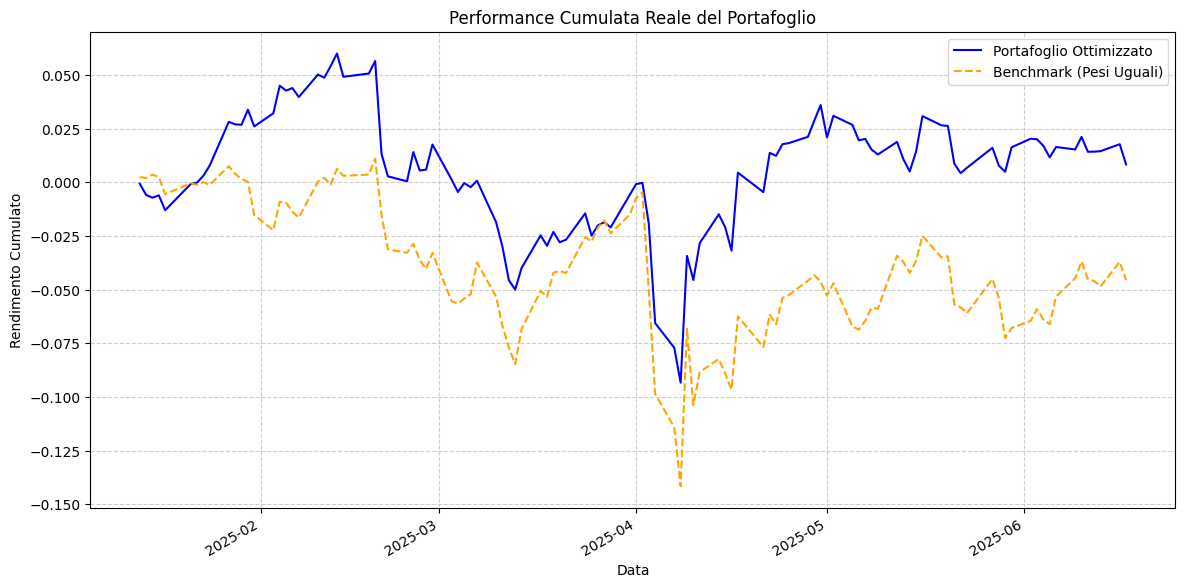

In [7]:
import yfinance as yf
from datetime import datetime

def evaluate_real_performance(simulated_log_returns_df, optimal_weights, start_date="2025-01-10"):
    # Estrazione dei ticker dalla colonna del DataFrame
    tickers = simulated_log_returns_df.columns.tolist()
    optimal_weights_series = pd.Series(optimal_weights, index=tickers)
    end_date = datetime.today().strftime('%Y-%m-%d')
    
    print(f"Valutazione portafoglio dal {start_date} al {end_date}")
    print("Pesi utilizzati (da simulazione):")
    print(optimal_weights_series.apply(lambda x: f"{x:.2%}"))
    
    # Scarica i prezzi
    prices = yf.download(tickers, start=start_date, end=end_date)['Close']
    if prices.empty:
        raise ValueError("Dati mancanti, verifica ticker o periodo probabilmente hai sbagliato ticker o non esiste il ticker su Yahoo Finance")
    
    # Calcola i rendimenti
    daily_returns = prices.pct_change().dropna()
    portfolio_returns = daily_returns.dot(optimal_weights_series)
    benchmark_returns = daily_returns.mean(axis=1)
    
    # Calcolo rendimenti cumulati
    portfolio_cum = (1 + portfolio_returns).cumprod()
    benchmark_cum = (1 + benchmark_returns).cumprod()
    
    # Stampa dei risultati
    print("\n--- Performance Reale ---")
    print(f"Rendimento cumulato portafoglio ottimizzato: {(portfolio_cum.iloc[-1] - 1)*100:.2f}%")
    print(f"Rendimento cumulato benchmark (pesi uguali): {(benchmark_cum.iloc[-1] - 1)*100:.2f}%")
    
    # Visualizzazione
    plt.figure(figsize=(14, 7))
    (portfolio_cum - 1).plot(label='Portafoglio Ottimizzato', color='blue')
    (benchmark_cum - 1).plot(label='Benchmark (Pesi Uguali)', linestyle='--', color='orange')
    plt.title('Performance Cumulata Reale del Portafoglio')
    plt.xlabel('Data')
    plt.ylabel('Rendimento Cumulato')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

evaluate_real_performance(simulated_log_returns_df, weights)